# Dataset

In [ ]:
import pandas
import numpy as np

In [ ]:
# read data
filepath = '/content/drive/Shareddrives/ARLP/Abhiraj Lakkamraju/UV Synthesized Nanolignin Based SC/ML Work/Battery_RUL.csv'

df = pandas.read_csv(filepath)
df.head()

,Cycle_Index,Discharge Time (s),Decrement 3.6-3.4V (s),Max. Voltage Dischar. (V),Min. Voltage Charg. (V),Time at 4.15V (s),Time constant current (s),Charging time (s),RUL
0,1.0,2595.30,1151.488500,3.670,3.211,5460.001,6755.01,10777.82,1112
1,2.0,7408.64,1172.512500,4.246,3.220,5508.992,6762.02,10500.35,1111
2,3.0,7393.76,1112.992000,4.249,3.224,5508.993,6762.02,10420.38,1110
3,4.0,7385.50,1080.320667,4.250,3.225,5502.016,6762.02,10322.81,1109
4,6.0,65022.75,29813.487000,4.290,3.398,5480.992,53213.54,56699.65,1107


In [ ]:
from scipy import stats

# remove outliers and Cycle Index
df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]
df = df.drop(columns='Cycle_Index')
df

,Discharge Time (s),Decrement 3.6-3.4V (s),Max. Voltage Dischar. (V),Min. Voltage Charg. (V),Time at 4.15V (s),Time constant current (s),Charging time (s),RUL
0,2595.30,1151.488500,3.670,3.211,5460.001000,6755.01,10777.82,1112
5,3301.18,1194.235077,3.674,3.504,5023.633636,5977.38,5977.38,1106
6,5955.30,1220.135329,4.013,3.501,5017.495000,5967.55,5967.55,1105
7,5951.20,1220.135329,4.014,3.501,5017.496000,5962.21,5962.21,1104
8,5945.44,1216.920914,4.014,3.501,5009.993667,5954.91,5954.91,1103
...,...,...,...,...,...,...,...,...
15058,773.00,180.480000,3.774,3.742,922.712000,1412.31,6659.62,5
15059,770.44,179.523810,3.773,3.742,922.775000,1412.38,6678.88,4
15060,771.12,179.523810,3.773,3.744,915.512000,1412.31,6670.38,3
15061,769.12,179.357143,3.773,3.742,915.513000,1412.31,6637.12,2


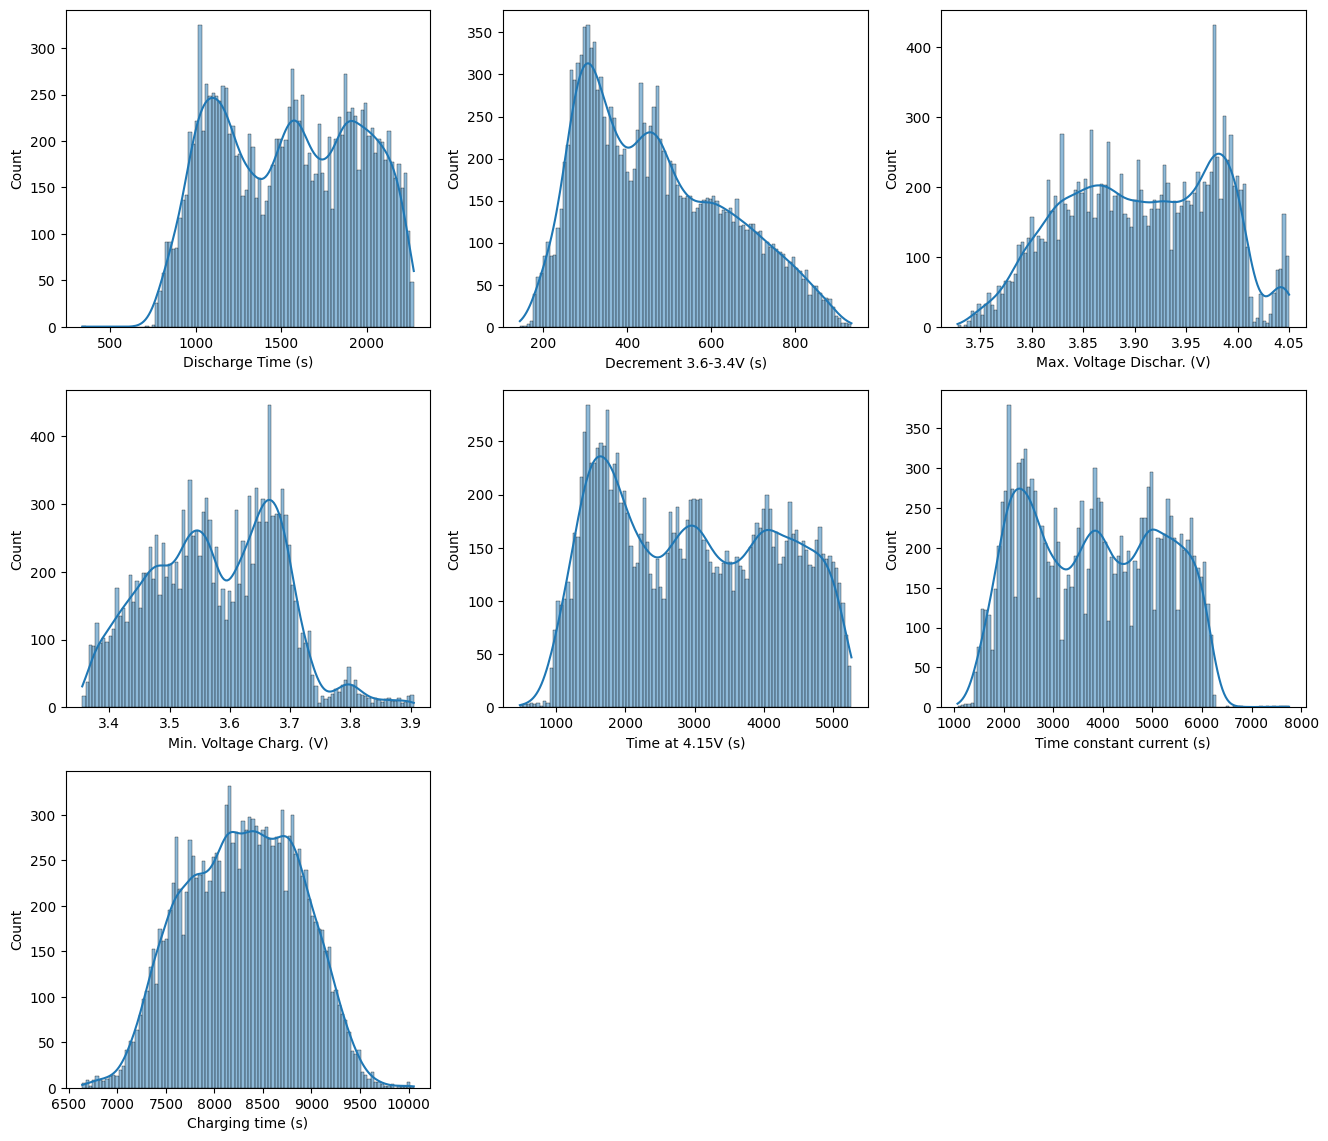

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# plot each column with RUL as the Y axis
plt.figure(figsize=(16,14))
for i,col in enumerate(df.columns[:-1]):
    plt.subplot(3, 3, i + 1)
    sns.histplot(x=col, data=df, bins=100, kde=True)

plt.show()

# fig, axs = plt.subplots(2,4, sharex=True)
# axs[0,0].scatter(df.loc[:,'Discharge Time (s)'], df.loc[:,'RUL'])
# axs[0,0].set_title('Discharge Time')
# axs[0,1].scatter(df.loc[:,'Decrement 3.6-3.4V (s)'], df.loc[:,'RUL'])
# axs[0,1].set_title('Decrement 3.6-3.4V')
# axs[0,2].scatter(df.loc[:,'Max. Voltage Dischar. (V)'], df.loc[:,'RUL'])
# axs[0,2].set_title('Max. Voltage Dischar.')
# axs[0,3].scatter(df.loc[:,'Min. Voltage Charg. (V)'], df.loc[:,'RUL'])
# axs[0,3].set_title('Min. Voltage Charg. (V)')
# axs[1,0].scatter(df.loc[:,'Time at 4.15V (s)'], df.loc[:,'RUL'])
# axs[1,0].set_title('Time at 4.15V')
# axs[1,1].scatter(df.loc[:,'Time constant current (s)'], df.loc[:,'RUL'])
# axs[1,1].set_title('Time constant current')
# axs[1,2].scatter(df.loc[:,'Charging time (s)'], df.loc[:,'RUL'])
# axs[1,2].set_title('Charging time')

# Predicting Remaining Useful Battery Life

In [ ]:
metrics = pandas.DataFrame(
    index=[
        'Linear','Ridge','kNN'
        ,'RandomForest'
        ,'Polynomial'
        ,'GradientBoosting'
        ,'DenseNN'
    ],
    columns=['R2_best','R2_1_feature','R2_2_features','R2_3_features',
             'MAE_best','MAE_1_feature','MAE_2_features', 'MAE_3_features'])

In [ ]:
from sklearn.model_selection import KFold, cross_validate
from sklearn.feature_selection import SequentialFeatureSelector

def apply_regressor(reg, X, y):

    """
    For the given regressor reg, the function will select best feature sets,
    perform cross-validation and return the following list of metrics:

    R^2 - best in test
    R^2 - best with regression with 1 feature
    R^2 - best with regression with 2 features
    R^2 - best with regression with 3 features
    MAE - best in test (see note below)
    MAE - with regression with 1 feature
    MAE - with regression with 2 features
    MAE - with regression with 3 features

    SequentialFeatureSelector selects by R^2. Therefore the MAE values
    returned by apply_regressor are not necessarily best, they are rather values
    corresponding to the best R^2 values.

    """

    R2_best = 0.0
    R2_1_feature = 0.0
    R2_2_features = 0.0
    R2_3_features = 0.0
    MAE_best = 1e100
    MAE_1_feature = 0.0
    MAE_2_features = 0.0
    MAE_3_features = 0.0

    kf = KFold(n_splits=5, shuffle=True, random_state=0)

    print('R^2       RMSE    MAE     best features')
    print('-----------------------------------------------')

    n_col = X.shape[1]

    for n_f in range(1, n_col + 1):

        if n_f == n_col:
            df_Xf = X
        else:
            sfs = SequentialFeatureSelector(reg, n_features_to_select=n_f)
            df_Xf = sfs.fit_transform(X, y)

        cv=cross_validate(reg, df_Xf, y, scoring=['r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_error'], cv=kf)

        if n_f == n_col:
            best_f = '[ALL]'
        else:
            best_f = sfs.get_support(indices=True) + 1

        R2 = cv['test_r2'].mean()
        RMSE = -cv['test_neg_root_mean_squared_error'].mean()
        MAE = -cv['test_neg_mean_absolute_error'].mean()

        if n_f == 1:
            R2_1_feature = R2
            MAE_1_feature = MAE

        if n_f == 2:
            R2_2_features = R2
            MAE_2_features = MAE

        if n_f == 3:
            R2_3_features = R2
            MAE_3_features = MAE

        if R2 > R2_best: R2_best = R2
        if MAE < MAE_best: MAE_best = MAE

        # print(cv['test_r2'].std())

        print('{:.4f}   {:.2f}   {:.2f}  '.format(R2, RMSE, MAE), best_f)

    return [R2_best, R2_1_feature, R2_2_features, R2_3_features, MAE_best, MAE_1_feature, MAE_2_features, MAE_3_features]

In [ ]:
from sklearn.preprocessing import MinMaxScaler

MMS_X = MinMaxScaler()
mms_y = MinMaxScaler()
df_X = pandas.DataFrame(MMS_X.fit_transform(df.iloc[:,:-1]), columns=list(df.columns[:-1]))
df_y = pandas.DataFrame(mms_y.fit_transform(df[['RUL']]), columns=['RUL'])

Linear Models

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge

metrics.loc['Linear'] = apply_regressor(LinearRegression(fit_intercept=True), df_X, df.RUL)
print()
metrics.loc['Ridge'] = apply_regressor(Ridge(alpha=3.0, fit_intercept=True), df_X, df.RUL)

R2       RMSE    MAE     best features
-----------------------------------------------
0.9753   50.01   36.89   [1]
0.9762   49.06   36.69   [1 5]
0.9765   48.83   36.59   [1 4 5]
0.9766   48.67   36.11   [1 2 4 5]
0.9766   48.65   36.11   [1 2 4 5 6]
0.9781   47.07   35.75   [1 2 3 4 5 6]
0.9787   46.44   35.12   [ALL]

R2       RMSE    MAE     best features
-----------------------------------------------
0.9752   50.05   36.86   [1]
0.9762   49.12   36.87   [1 5]
0.9765   48.83   36.64   [1 4 5]
0.9765   48.77   36.49   [1 2 4 5]
0.9765   48.82   36.45   [1 2 4 5 6]
0.9779   47.27   36.19   [1 2 3 4 5 6]
0.9786   46.62   35.45   [ALL]


K Nearest Neighbors

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

kNN1 = apply_regressor(KNeighborsRegressor(n_neighbors=2), df_X, df.RUL)
kNN2 = apply_regressor(KNeighborsRegressor(n_neighbors=3), df_X, df.RUL)
kNN3 = apply_regressor(KNeighborsRegressor(n_neighbors=4), df_X, df.RUL)
kNN4 = apply_regressor(KNeighborsRegressor(n_neighbors=5), df_X, df.RUL)
kNN5 = apply_regressor(KNeighborsRegressor(n_neighbors=6), df_X, df.RUL)
kNN_all = [ kNN1, kNN2, kNN3, kNN4, kNN5 ]
kNN_R2_best = np.argmax([L[0] for L in kNN_all])
metrics.loc['kNN'] = kNN_all[kNN_R2_best]

R2       RMSE    MAE     best features
-----------------------------------------------
0.9682   56.74   38.71   [6]
0.9708   54.43   38.38   [5 6]
0.9780   47.26   30.32   [1 5 6]
0.9912   29.92   14.70   [1 3 5 6]
0.9948   22.93   9.63   [1 2 3 5 6]
0.9966   18.54   7.07   [1 2 3 5 6 7]
0.9974   16.13   5.68   [ALL]
R2       RMSE    MAE     best features
-----------------------------------------------
0.9710   54.11   37.46   [6]
0.9737   51.65   36.95   [5 6]
0.9801   44.91   29.72   [1 5 6]
0.9914   29.57   15.81   [1 3 5 6]
0.9948   22.93   10.72   [1 2 3 5 6]
0.9965   18.63   7.74   [1 2 3 5 6 7]
0.9974   16.20   6.21   [ALL]
R2       RMSE    MAE     best features
-----------------------------------------------
0.9727   52.60   37.19   [1]
0.9776   47.61   32.77   [1 6]
0.9809   43.99   29.66   [1 5 6]
0.9914   29.45   16.63   [1 3 5 6]
0.9946   23.35   11.72   [1 2 3 5 6]
0.9967   18.14   7.63   [1 2 3 4 5 6]
0.9972   16.72   6.69   [ALL]
R2       RMSE    MAE     best features
--

Random Forests

In [ ]:
from sklearn.ensemble import RandomForestRegressor

metrics.loc['RandomForest'] = apply_regressor(RandomForestRegressor(random_state=0, n_estimators=60), df_X, df.RUL)

R2       RMSE    MAE     best features
-----------------------------------------------
0.9747   50.62   35.35   [6]
0.9753   50.07   35.43   [5 6]
0.9815   43.36   29.56   [1 5 6]
0.9919   28.58   17.36   [1 3 5 6]
0.9945   23.60   14.03   [1 2 3 5 6]
0.9963   19.43   10.66   [1 2 3 4 5 6]
0.9972   16.73   8.57   [ALL]


Polynomial Regression

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

# Try various polynomial functions
poly = PolynomialFeatures(7, include_bias=False)
dfp = df_X.copy()
dfp = poly.fit_transform(dfp)
dfp = pandas.DataFrame(dfp)
dfp.shape

(14353, 3431)

In [ ]:
# see which models performed the best
lst = (dfp.corrwith(df_y.iloc[:,0]).abs().sort_values()).reset_index()
of = poly.get_feature_names_out()
for i in lst.index:
    lst.loc[i,'terms'] = of[lst.iloc[i,0]]

lst.tail(15)

,index,0,terms
3416,29,0.959045,Time at 4.15V (s)^2
3417,2,0.959858,Max. Voltage Dischar. (V)
3418,13,0.959898,Discharge Time (s) Charging time (s)
3419,22,0.961482,Max. Voltage Dischar. (V) Time at 4.15V (s)
3420,30,0.961531,Time at 4.15V (s) Time constant current (s)
3421,24,0.963484,Max. Voltage Dischar. (V) Charging time (s)
3422,23,0.963960,Max. Voltage Dischar. (V) Time constant curren...
3423,1,0.964563,Decrement 3.6-3.4V (s)
3424,11,0.970393,Discharge Time (s) Time at 4.15V (s)
3425,9,0.970589,Discharge Time (s) Max. Voltage Dischar. (V)


In [ ]:
# we can add the three best new features into the model
dfpoly = df_X.copy()
dfpoly['F8'] = df_X['Discharge Time (s)']**2
dfpoly['F9'] = df_X['Discharge Time (s)'] * df_X['Time constant current (s)']
dfpoly['F10'] = df_X['Discharge Time (s)'] * df_X['Max. Voltage Dischar. (V)']

# add performance to metrics
metrics.loc['Polynomial'] = apply_regressor(LinearRegression(fit_intercept=True), dfpoly, df.RUL)

R2       RMSE    MAE     best features
-----------------------------------------------
0.9629   61.55   41.64   [5]
0.9650   59.84   40.63   [4 5]
0.9681   57.16   41.26   [3 4 5]
0.9682   57.05   41.25   [1 3 4 5]
0.9689   56.42   40.38   [ 1  3  4  5 10]
0.9688   56.51   40.53   [ 1  2  3  4  5 10]
0.9682   57.04   40.50   [ 1  2  3  4  5  6 10]
0.9690   56.28   40.75   [ 1  2  3  4  5  6  7 10]
0.9303   75.92   40.62   [ 1  2  3  4  5  6  7  8 10]
0.7807   109.18   40.97   [ALL]


Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

# Estimate the best learning rate using the features (works very slow, but necessary to get optimal learning rate)
lr_best = 0
R2_best = 0

for i in range(200):
    learning_rate=0.01 + i/200
    cv=cross_validate(GradientBoostingRegressor(learning_rate=learning_rate),
               df_X, df.RUL, scoring=['r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_error'],
               cv=KFold(n_splits=5, shuffle=True, random_state=0))
    R2 = cv['test_r2'].mean()
    print('{}  {:.4f}   {:.2f}   {:.2f}  '.format(i,
            R2,
            -cv['test_neg_root_mean_squared_error'].mean(),
            -cv['test_neg_mean_absolute_error'].mean()))
    if R2 > R2_best:
        R2_best = R2
        lr_best = learning_rate

print('Best R2: {} with learning_rate = {}'.format(R2_best, lr_best))

0  0.8409   127.68   107.81  
1  0.9272   86.33   71.68  
2  0.9600   63.97   52.49  


KeyboardInterrupt: 

In [ ]:
lr_best = 0.99 # arbitrary value is chosen to save time, but this should be determined by the previous cell
metrics.loc['GradientBoosting'] = apply_regressor(GradientBoostingRegressor(random_state=0, learning_rate = lr_best), df_X, df.RUL)

R2       RMSE    MAE     best features
-----------------------------------------------
0.9731   52.52   35.91   [1]
0.9745   51.12   34.47   [1 6]
0.9754   50.13   34.19   [1 5 6]
0.9838   40.71   28.23   [1 3 5 6]
0.9865   37.14   25.49   [1 2 3 5 6]
0.9875   35.78   24.29   [1 2 3 4 5 6]
0.9895   32.78   21.70   [ALL]


Dense Neural Network

In [ ]:
# function to see the loss of the model over training
def plot_loss(history, opt, act):
    plt.plot(history.history['loss'], label='loss')

    try:
        plt.plot(history.history['val_loss'], label='val_loss')
    except:
        print('No validation data')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Optimizer: {}, activation function: {}'.format(opt, act))
    plt.grid(True)

116/116 [==============================] - 0s 1ms/step
0.9755901222639508 49.562159979858876 37.07128219311731


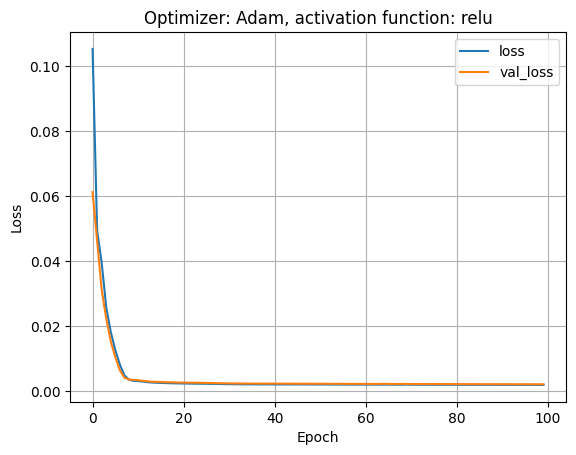

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

model = Sequential()
opt = 'Adam'
act = 'relu'
model.add(Dense(35, input_dim=7, activation=act))
model.add(Dense(35, activation=act))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer=opt)

df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(df_X, df_y, shuffle=True, random_state=0)
hist = model.fit(df_X_train, df_y_train, epochs=100, validation_split=0.2, batch_size=1000, verbose=0)
y_pred = model.predict(df_X_test)

df_y_test_inv = mms_y.inverse_transform(df_y_test)
y_pred_inv = mms_y.inverse_transform(y_pred)

print(r2_score(df_y_test, y_pred),
    mean_squared_error(df_y_test_inv, y_pred_inv)**0.5,
    mean_absolute_error(df_y_test_inv, y_pred_inv))

plot_loss(hist, opt, act) # should try this with many optimizers in order to determine the most optimal one

In [ ]:
# cross validation function
def cross_val(X, y, mmsy):

    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    R2_list = []
    RMSE_list = []
    MAE_list = []

    for i, (train_index, test_index) in enumerate(kf.split(X)):

        model = Sequential()
        model.add(Dense(50, input_dim=X.shape[1], activation='relu'))
        model.add(Dense(50, activation='relu'))
        model.add(Dense(y.shape[1], activation='linear'))
        model.compile(loss='mse', optimizer='Adam')

        hist = model.fit(X.iloc[train_index], y.iloc[train_index], epochs=70, validation_split=0.0, batch_size=1000, verbose=0)
        y_pred = model.predict(X.iloc[test_index])

        y_test_inv = mmsy.inverse_transform(y.iloc[test_index])
        y_pred_inv = mmsy.inverse_transform(y_pred)

        R2 = r2_score(y.iloc[test_index], y_pred)
        RMSE = mean_squared_error(y_test_inv, y_pred_inv)**0.5
        MAE = mean_absolute_error(y_test_inv, y_pred_inv)

        R2_list.append(R2)
        RMSE_list.append(RMSE)
        MAE_list.append(MAE)

    return [np.mean(R2_list), np.mean(RMSE_list), np.mean(MAE_list)]

In [ ]:
# select best feature combinations
best_R2 = [0,0,0,0,0,0,0]
best_MAE = [1e10,1e10,1e10,1e10,1e10,1e10,1e10]
best_features = [[],[],[],[],[],[],[]]

for i in range(1,128):

    print(i)

    X = df_X.iloc[:,[1 == (i // 2**n) % 2 for n in range(0,7)]]
    n_features = len(X.columns)

    (R2, _, MAE) = cross_val(X, df_y, mms_y)

    if R2 > best_R2[n_features - 1]:
        best_R2[n_features - 1] = R2
        best_features[n_features - 1] = list(X.columns)
        #if best_MAE[n_features - 1] > MAE:
        best_MAE[n_features - 1] = MAE

1
92/92 [==============================] - 0s 2ms/step
2
92/92 [==============================] - 0s 1ms/step
3
92/92 [==============================] - 0s 1ms/step
4
92/92 [==============================] - 0s 1ms/step
5
92/92 [==============================] - 0s 2ms/step
6
92/92 [==============================] - 0s 4ms/step
7
92/92 [==============================] - 0s 2ms/step
8
92/92 [==============================] - 0s 1ms/step
9
92/92 [==============================] - 0s 2ms/step
10
92/92 [==============================] - 0s 1ms/step
11
92/92 [==============================] - 0s 2ms/step


KeyboardInterrupt: 

In [ ]:
best_R2 # dense NN feature selection was stopped prematurely to save time

[0.9742231575065992, 0.9721314847868469, 0.9423939134197896, 0, 0, 0, 0]

In [ ]:
print('Best R2 value is attained with {} features.'.format(1 + np.argmax(best_R2)))

Best R2 value is attained with 1 features.


In [ ]:
best_MAE

[36.74160575409554,
 37.3241022765774,
 60.828455275138154,
 10000000000.0,
 10000000000.0,
 10000000000.0,
 10000000000.0]

In [ ]:
best_features

[['Discharge Time (s)'],
 ['Discharge Time (s)', 'Decrement 3.6-3.4V (s)'],
 ['Discharge Time (s)', 'Decrement 3.6-3.4V (s)', 'Max. Voltage Dischar. (V)'],
 [],
 [],
 [],
 []]

In [ ]:
metrics.loc['DenseNN'] = [max(best_R2), best_R2[0], best_R2[1], best_R2[2], min(best_MAE), best_MAE[0], best_MAE[1], best_MAE[2]]

Comparing the Performance of Different Models

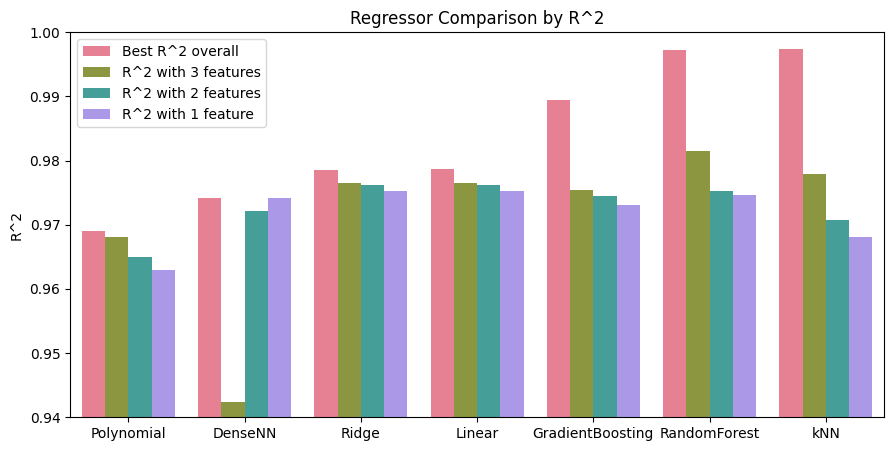

In [ ]:
# metrics sorted by best R^2 value
metrics_sorted = metrics.sort_values('R2_best')

metrics_melted = pandas.melt(
    metrics_sorted.reset_index()[['index','R2_best','R2_3_features','R2_2_features','R2_1_feature']],
    id_vars='index')

bar_labels_r2 = {
        'R2_best' : 'Best R^2 overall',
        'R2_1_feature' : 'R^2 with 1 feature',
        'R2_2_features' : 'R^2 with 2 features',
        'R2_3_features' : 'R^2 with 3 features'
    }

metrics_melted.variable = metrics_melted.variable.apply(lambda x: bar_labels_r2[x])

plt.figure(figsize=(10.5, 5))
sns.barplot(data=metrics_melted, x='index', y='value', hue='variable', palette='husl')
plt.legend(loc='upper left')
plt.xlabel('')
plt.ylabel('R^2')
plt.title('Regressor Comparison by R^2')
plt.ylim(0.94, 1)
plt.show()

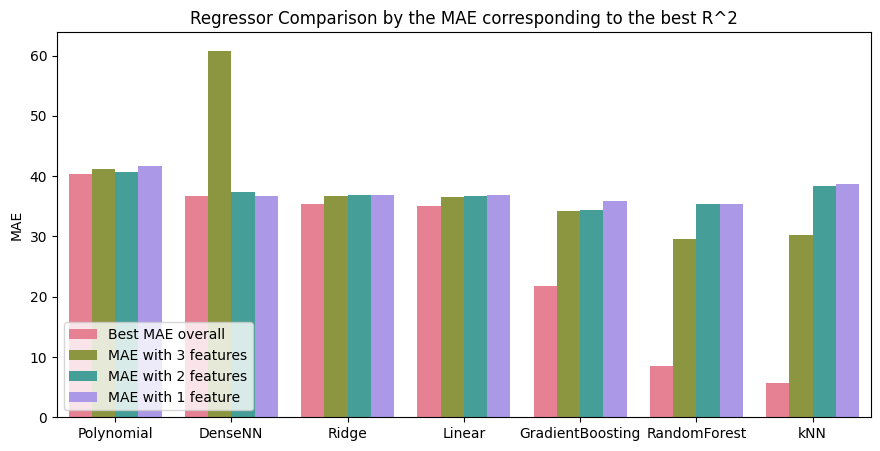

In [ ]:
# metrics sorted by best mean absolute error
metrics_sorted = metrics.sort_values('MAE_best', ascending=False)

metrics_melted = pandas.melt(
    metrics_sorted.reset_index()[['index','MAE_best','MAE_3_features','MAE_2_features','MAE_1_feature']],
    id_vars='index')

bar_labels_mae = {
        'MAE_best' : 'Best MAE overall',
        'MAE_1_feature' : 'MAE with 1 feature',
        'MAE_2_features' : 'MAE with 2 features',
        'MAE_3_features' : 'MAE with 3 features'
    }

metrics_melted.variable = metrics_melted.variable.apply(lambda x: bar_labels_mae[x])

plt.figure(figsize=(10.5, 5))
sns.barplot(data=metrics_melted, x='index', y='value', hue='variable', palette='husl')
plt.legend(loc='lower left')
plt.xlabel('')
plt.ylabel('MAE')
plt.title('Regressor Comparison by the MAE corresponding to the best R^2')
plt.show()

# Find the Best Input Combination

Steady State Genetic Algorithm

In [ ]:
# create fitness function using best performing model
model = KNeighborsRegressor(n_neighbors=2)
model.fit(df_X.values, df_y.values)
def fitness(chrom):
  return 0.01*model.predict([chrom])[0,0]

In [ ]:
# create initial population
pop_size = 200
population = []

for i in range(0,pop_size):
  chromosome = []
  for j in df.columns[:-1]:
    chromosome.append(np.random.uniform(df[j].min(), df[j].max()))
  population.append([chromosome, fitness(chromosome)])

print(len(population))
population = sorted(population, key=lambda x:x[1], reverse=True)
print(len(population))

In [ ]:
# start iteration
num_gen = 10000
generation = 0
while generation < num_gen:
  if generation%100 == 0:
    print('Generation ' + str(generation))
  num_children = pop_size
  children = []
  total_fitness = sum([population[i][1] for i in range(pop_size-num_children,pop_size)])
  mut_rate = 0.25

  for i in range(pop_size-num_children):
    # crossover
    temp = np.random.uniform(total_fitness)
    par1 = 4
    while temp < total_fitness and par1 < pop_size:
      temp += population[par1][1]
      par1 += 1

    temp = np.random.uniform(total_fitness)
    par2 = 4
    while temp < total_fitness and par2 < pop_size:
      temp += population[par2][1]
      par2 += 1

    coin_odds = population[par1][1] / (population[par1][1] + population[par2][1])
    child = []
    for j in range(len(population[par1][0])):
      if np.random.uniform() >= coin_odds:
        child.append(population[par2][0][j])
      else:
        child.append(population[par1][0][j])

    # mutation
    if np.random.uniform() < mut_rate:
      col = np.random.randint(0,len(child))
      child[col] += np.random.normal(scale=(df.max()[col] - df.min()[col])/6)

    # fitness calculation
    children.append([child, fitness(child)])

  # survivor selection
  population.extend(children)
  population = sorted(population, key=lambda x:x[1], reverse=True)[:pop_size]

  if generation%100 == 0:
    print('\tTop Fitness Score: ' + str(population[0][1]))

  generation += 1

Generation 0
	Top Fitness Score: 0.007062720848056537
Generation 100
	Top Fitness Score: 0.007062720848056537
Generation 200
	Top Fitness Score: 0.007062720848056537
Generation 300
	Top Fitness Score: 0.007062720848056537
Generation 400
	Top Fitness Score: 0.007062720848056537
Generation 500
	Top Fitness Score: 0.007062720848056537
Generation 600
	Top Fitness Score: 0.007062720848056537
Generation 700
	Top Fitness Score: 0.007062720848056537
Generation 800
	Top Fitness Score: 0.007062720848056537
Generation 900
	Top Fitness Score: 0.007062720848056537
Generation 1000
	Top Fitness Score: 0.007062720848056537
Generation 1100
	Top Fitness Score: 0.007062720848056537
Generation 1200
	Top Fitness Score: 0.007062720848056537
Generation 1300
	Top Fitness Score: 0.007062720848056537
Generation 1400
	Top Fitness Score: 0.007062720848056537
Generation 1500
	Top Fitness Score: 0.007062720848056537
Generation 1600
	Top Fitness Score: 0.007062720848056537
Generation 1700
	Top Fitness Score: 0.00706

# AutoEncoder

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets,transforms
import matplotlib.pyplot as plt

In [ ]:
transform = transforms.ToTensor()
mnist_data = datasets.MNIST(root='./data',train=True,download=True, transform=transform)
data_loader = torch.utils.data.DataLoader(dataset=mnist_data, batch_size=64, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 110958217.56it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 33297332.00it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 31850652.34it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 14206210.86it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
dataiter = iter(data_loader)
images, labels = next(dataiter)

In [ ]:
class AutoEncoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(
      nn.Conv2d(1, 16, 3,stride=2, padding=1),
      nn.ReLU(),
      nn.Conv2d(16, 32, 3,stride=2, padding=1),
      nn.ReLU(),
      nn.Conv2d(32, 64, 7)
    )

    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(64,32,7),
        nn.ReLU(),
        nn.ConvTranspose2d(32,16,3,stride=2,padding=1,output_padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(16,1,3,stride=2,padding=1,output_padding=1),
        nn.Sigmoid(),
    )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [ ]:
model = AutoEncoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [ ]:
num_epochs=10
outputs=[]
for epoch in range(num_epochs):
  for(img,_) in data_loader:
    recon=model(img)
    loss=criterion(recon,img)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
  outputs.append((epoch,img,recon))

Epoch:1, Loss:0.0094
Epoch:2, Loss:0.0057
Epoch:3, Loss:0.0051
Epoch:4, Loss:0.0035
Epoch:5, Loss:0.0026
Epoch:6, Loss:0.0034
Epoch:7, Loss:0.0028
Epoch:8, Loss:0.0026
Epoch:9, Loss:0.0025
Epoch:10, Loss:0.0034


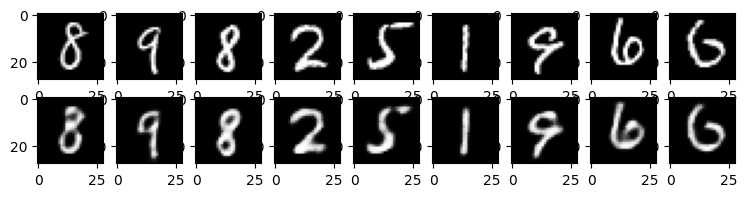

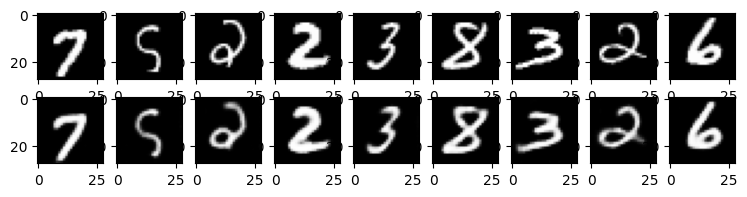

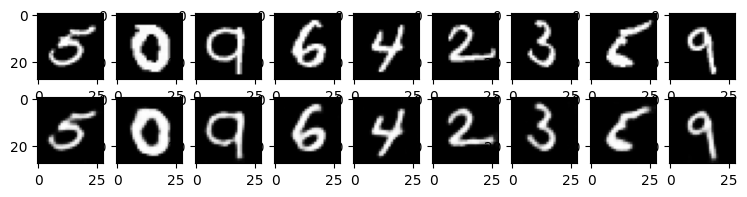

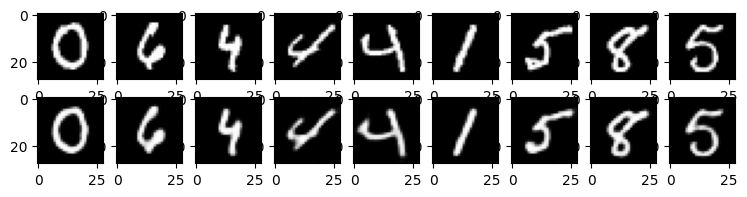

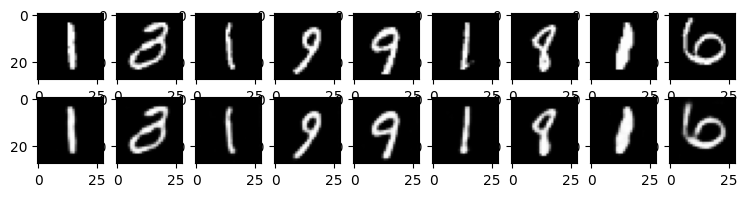

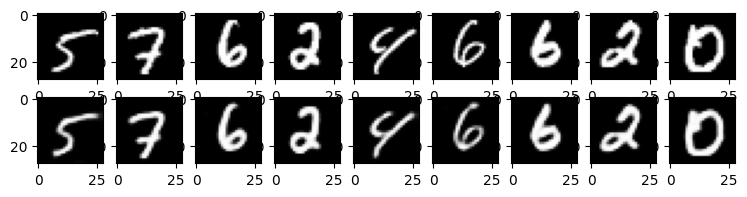

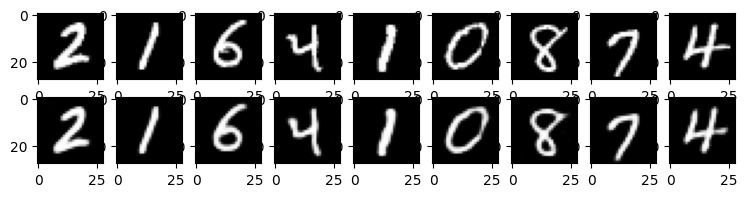

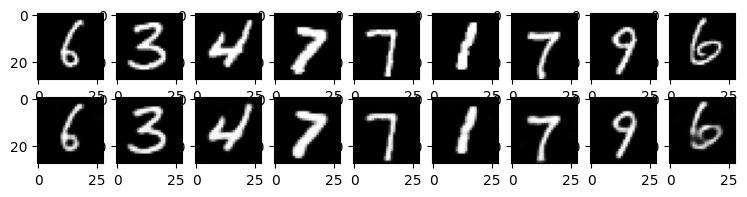

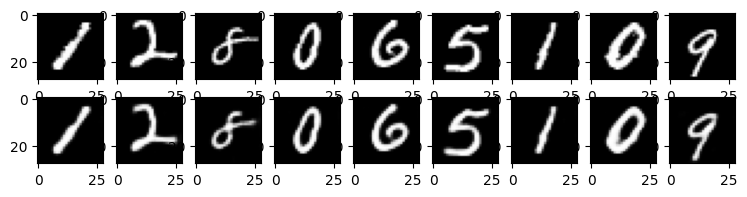

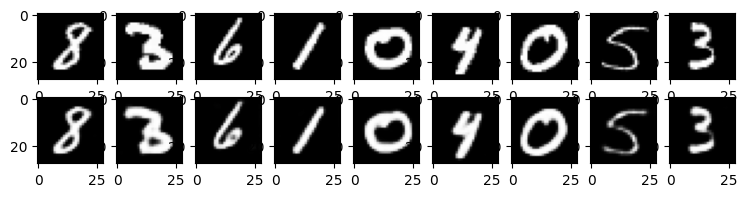

In [ ]:
for k in range(num_epochs):
  plt.figure(figsize=(9,2))
  plt.gray()
  imgs = outputs[k][1].detach().numpy()
  recon = outputs[k][2].detach().numpy()
  for i, item in enumerate(imgs):
    if i >= 9:break
    plt.subplot(2,9,i+1)
    plt.imshow(item[0])

  for i, item in enumerate(recon):
    if i>= 9:break
    plt.subplot(2,9,9+i+1)
    plt.imshow(item[0])